In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
from matplotlib import patches, image
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML

from helpers import *

## Load all fixations

In [2]:
base_dir = os.path.realpath('../..')
print(base_dir)
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study2_EyeTracking


In [4]:
eye = 'average'
fix_pct_LT = pd.read_csv(base_dir + 
                '/Data/'+
                'all_fixations_as_pct_LT_eye-%s.csv'%eye,index_col=0)
fix_pct_LT.head()

,sub,part,block,player_type,trial,num,num_S_T,dur_pct
0,5,1,1.0,opt_nat,1,10_1,no_S_T,0.123562
1,5,1,1.0,opt_nat,1,10_2,no_S_T,0.113534
2,5,1,1.0,opt_nat,1,5_1,no_S_T,0.000000
3,5,1,1.0,opt_nat,1,5_2,no_S_T,0.000000
4,5,1,1.0,opt_nat,1,S_1,S,0.108974


## Compute trial-wise S/T gaze balance (ratio? difference?)

In [5]:
ratio_dat = fix_pct_LT.query('num_S_T == "S" or num_S_T == "T"').copy().reset_index(drop=True)
ratio_dat = ratio_dat.groupby(['sub','part','block','trial','player_type','num_S_T']).sum().reset_index().copy()
ratio_dat = ratio_dat.pivot_table(
    index = ['sub','part','block','player_type','trial'],
    columns = 'num_S_T', values = 'dur_pct').reset_index()
ratio_dat.fillna(value = 0, inplace=True)
ratio_dat['diff T>S'] = ratio_dat['T'] - ratio_dat['S']
ratio_dat['ratio T>S'] = ratio_dat['T'] / ratio_dat['S']
ratio_dat['log ratio T>S'] = np.log(ratio_dat['T'] / ratio_dat['S'])
# ratio_dat.replace(to_replace={np.inf:1,-np.inf:-1},inplace=True)
ratio_dat.head(n=10)

/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


num_S_T,sub,part,block,player_type,trial,S,T,diff T>S,ratio T>S,log ratio T>S
0,5,1,1.0,opt_nat,1,0.108974,0.162304,0.053330,1.489388,0.398366
1,5,1,1.0,opt_nat,2,0.073163,0.048324,-0.024839,0.660499,-0.414760
2,5,1,1.0,opt_nat,3,0.041394,0.000000,-0.041394,0.000000,-inf
3,5,1,1.0,opt_nat,4,0.138244,0.076928,-0.061316,0.556467,-0.586147
4,5,1,1.0,opt_nat,5,0.128785,0.155268,0.026484,1.205644,0.187014
5,5,1,1.0,opt_nat,6,0.102185,0.102870,0.000685,1.006706,0.006684
6,5,1,1.0,opt_nat,7,0.042933,0.026722,-0.016211,0.622416,-0.474147
7,5,1,1.0,opt_nat,8,0.023115,0.310705,0.287590,13.441851,2.598373
8,5,1,1.0,opt_nat,9,0.037019,0.470397,0.433378,12.706966,2.542150
9,5,1,1.0,opt_nat,10,0.141243,0.126089,-0.015154,0.892709,-0.113495


## Get gaze predictions from model

In [6]:
gaze_predictions = pd.DataFrame()
for sub_ind in np.arange(151,201):
    filename = (base_dir + '/Data/'+
                'Gaze_predict/'+
                'KL_gaze_predictions_sub-%i.csv'%sub_ind)
    gaze_predictions = gaze_predictions.append(pd.read_csv(filename, index_col = None))
gaze_predictions = gaze_predictions.reset_index(drop=True)
gaze_predictions['sub'] = gaze_predictions['subID'] - 5000
gaze_predictions = gaze_predictions.rename(columns = {'diff_T_S':'diff KL T>S'})
gaze_predictions['ratio KL T>S'] = gaze_predictions['KL_T'] / gaze_predictions['KL_S']
gaze_predictions['log ratio KL T>S'] = np.log(gaze_predictions['KL_T'] / gaze_predictions['KL_S'])
ratio_dat = ratio_dat.merge(gaze_predictions, on = ['sub','trial'])
ratio_dat.head()

,sub,part,block,player_type,trial,S,T,diff T>S,ratio T>S,log ratio T>S,subInd,subID,KL_S,KL_T,diff KL T>S,ratio KL T>S,log ratio KL T>S
0,5,1,1.0,opt_nat,1,0.108974,0.162304,0.053330,1.489388,0.398366,151,5005,0.533531,0.734199,0.200668,1.376113,0.319263
1,5,1,1.0,opt_nat,2,0.073163,0.048324,-0.024839,0.660499,-0.414760,151,5005,0.543836,0.741178,0.197341,1.362870,0.309593
2,5,1,1.0,opt_nat,3,0.041394,0.000000,-0.041394,0.000000,-inf,151,5005,0.553668,0.747767,0.194099,1.350569,0.300526
3,5,1,1.0,opt_nat,4,0.138244,0.076928,-0.061316,0.556467,-0.586147,151,5005,0.421370,0.828606,0.407236,1.966457,0.676233
4,5,1,1.0,opt_nat,5,0.128785,0.155268,0.026484,1.205644,0.187014,151,5005,0.307396,0.880786,0.573390,2.865314,1.052678


## Correlate observed to predicted gaze differences

In [7]:
scipy.stats.pearsonr(ratio_dat['diff T>S'], ratio_dat['diff KL T>S'])

(0.13948651976759524, 4.1089496243114354e-29)

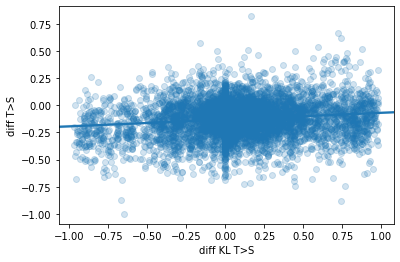

In [12]:
sns.regplot(data = ratio_dat, x = 'diff KL T>S', y = 'diff T>S', scatter_kws = {'alpha': .2})

## Visualize per subject the relationship between predicted and actual T>S difference

##### Supplementary Figure 8B

/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
findfont: Font family ['Ubuntu'] not found. Falling back

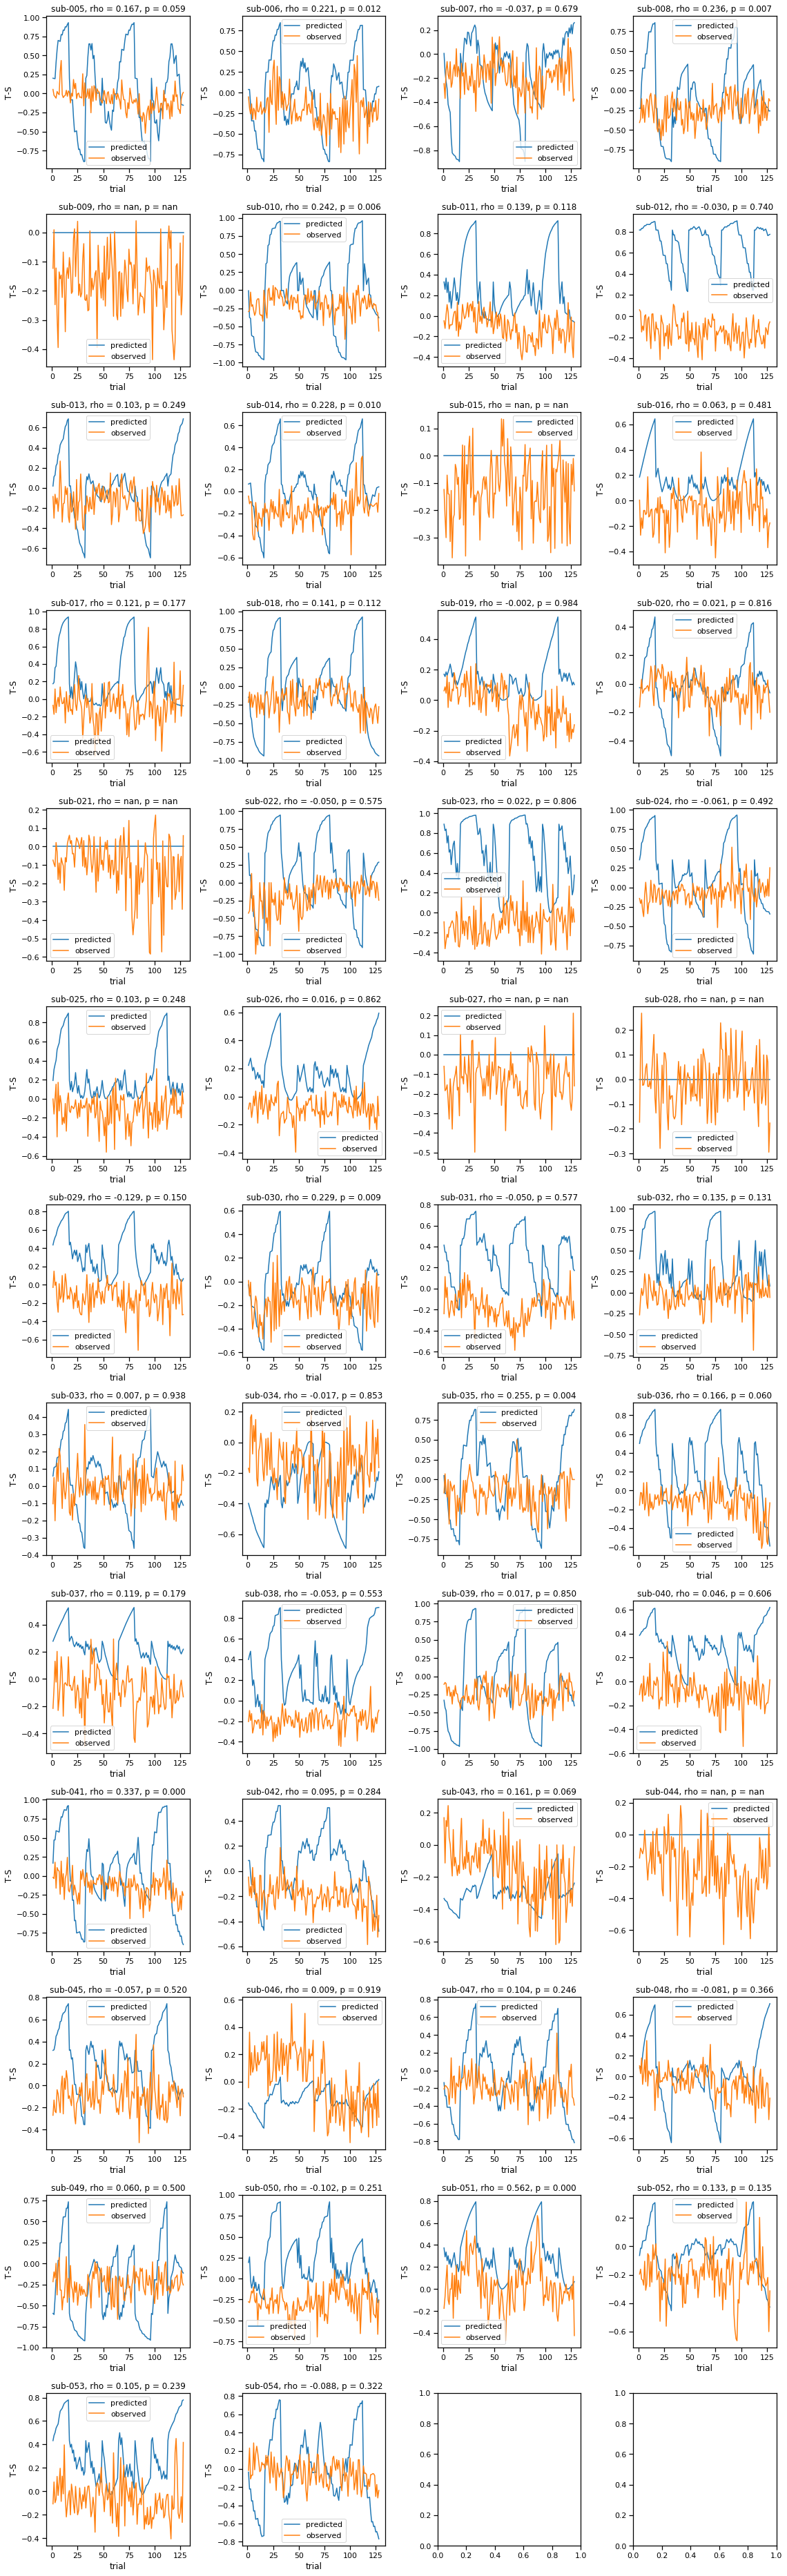

In [13]:
subs = ratio_dat['sub'].unique()
ncols = 4
nrows = int(round(np.ceil(len(subs)/ncols)))
sns.set_context('notebook')
fig, axes = plt.subplots(nrows,ncols, figsize = [16,nrows*4])

predicted_column = 'diff KL T>S'
empirical_column = 'diff T>S'
corr_results = pd.DataFrame(columns = ['sub','r','p'])

for subInd, ax in enumerate(axes.ravel()):
    if subInd < len(subs):
        sub = subs[subInd]
        gp_sub = ratio_dat.query('sub == @sub').copy().reset_index(drop=True)
        # Scale for visualization - ACTUALLY DO NOT SCALE
        gp_sub['predicted'] = (gp_sub[predicted_column] / 1)
#                                np.std(gp_sub[predicted_column]))
        gp_sub['empirical'] = (gp_sub[empirical_column] / 1)
#                                np.std(gp_sub[empirical_column]))
        # Plot
        sns.lineplot(data=gp_sub, x = 'trial', y = 'predicted', ax = ax, 
                     label = 'predicted', legend = 'brief')
        sns.lineplot(data=gp_sub, x = 'trial', y = 'empirical', ax = ax, 
                     label = 'observed', legend = 'brief')

        corr_result = scipy.stats.spearmanr(
            gp_sub.predicted, gp_sub.empirical)
        corr_results = corr_results.append(pd.DataFrame(
            [[sub,corr_result[0],corr_result[1]]], columns = corr_results.columns))
        ax.set(title = 'sub-%03d, rho = %.3f, p = %.3f'%(sub,corr_result[0],corr_result[1]),
              ylabel = 'T-S')
plt.tight_layout()

##### Supplementary Figure 8a

44
0.08199339129407196
Ttest_1sampResult(statistic=4.05367015008102, pvalue=0.00020772637116992843)
NormaltestResult(statistic=13.358125198514706, pvalue=0.0012569556916775947)
WilcoxonResult(statistic=186.0, pvalue=0.00031084595941699894)


findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


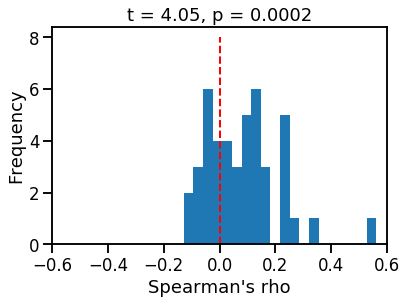

In [14]:
sns.set_context('talk')
t_dat = corr_results.copy().dropna()
plt.hist(t_dat.r,20)
print(len(t_dat))
t_results = scipy.stats.ttest_1samp(t_dat.r,0)
print(np.mean(t_dat.r))
print(t_results)
print(scipy.stats.normaltest(t_dat.r))
print(scipy.stats.wilcoxon(t_dat.r))
plt.xlabel('Spearman\'s rho')
plt.ylabel('Frequency')
plt.title('t = %.2f, p = %.4f'%(t_results[0], t_results[1]))
plt.xlim([-.6,.6])
plt.plot([0,0],[0,8],'r--', lw=2)

# Figure 4C

In [32]:
bestPerSubject_features = pd.read_csv(
    '/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/'+
    'Data/Cleaned/Model_results/Best_motives_per_participant.csv',index_col = 0, dtype={'comb':str})
# fix_pct_LT_model_features = fix_pct_LT.merge(bestPerSubject_features, on = 'sub')

In [33]:
bestPerSubject_features['Risk'] = bestPerSubject_features['comb'].apply(lambda x: x[2]=='1')

In [34]:
bestPerSubject_features.head()

,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,LR_down,...,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,best_model,model_descr,Risk
sub_ind,,,,,,,,,,,,,,,,,,,,,
151,5005,joint,6,0110,Greed_Risk,0,0,0,0.747,0.747,...,3.179,NaN,NaN,SSE,7.397,0.819,17.769,True,Best Motives,True
152,5006,joint,14,1110,Coop_Greed_Risk,0,0,0,0.114,0.114,...,0.495,0.473,NaN,SSE,4.209,36.928,-49.597,True,Best Motives,True
153,5007,joint,3,0011,Risk_Nash,0,0,0,1.544,1.544,...,3.645,NaN,NaN,SSE,7.439,0.472,18.464,True,Best Motives,True
154,5008,joint,7,0111,Greed_Risk_Nash,0,0,0,0.648,0.648,...,1.559,1.528,NaN,SSE,5.546,19.267,-14.274,True,Best Motives,True
155,5009,joint,9,1001,Coop_Nash,0,0,0,0.350,0.350,...,2.978,NaN,NaN,SSE,4.941,26.660,-33.913,True,Best Motives,False


In [35]:
ratio_dat['blocktrial'] = ratio_dat['trial'] - (ratio_dat['block']-1)*16

In [36]:
ratio_dat['trialbin'] = ratio_dat['blocktrial'].apply(lambda x: np.ceil(x/4))

In [37]:
ratio_dat = ratio_dat.merge(bestPerSubject_features[['sub_ID','Risk']], left_on = 'subID', right_on = 'sub_ID')

In [38]:
ratio_dat.head()

,sub,part,block,player_type,trial,S,T,diff T>S,ratio T>S,log ratio T>S,...,subID,KL_S,KL_T,diff KL T>S,ratio KL T>S,log ratio KL T>S,blocktrial,trialbin,sub_ID,Risk
0,5,1,1.0,opt_nat,1,0.108974,0.162304,0.053330,1.489388,0.398366,...,5005,0.533531,0.734199,0.200668,1.376113,0.319263,1.0,1.0,5005,True
1,5,1,1.0,opt_nat,2,0.073163,0.048324,-0.024839,0.660499,-0.414760,...,5005,0.543836,0.741178,0.197341,1.362870,0.309593,2.0,1.0,5005,True
2,5,1,1.0,opt_nat,3,0.041394,0.000000,-0.041394,0.000000,-inf,...,5005,0.553668,0.747767,0.194099,1.350569,0.300526,3.0,1.0,5005,True
3,5,1,1.0,opt_nat,4,0.138244,0.076928,-0.061316,0.556467,-0.586147,...,5005,0.421370,0.828606,0.407236,1.966457,0.676233,4.0,1.0,5005,True
4,5,1,1.0,opt_nat,5,0.128785,0.155268,0.026484,1.205644,0.187014,...,5005,0.307396,0.880786,0.573390,2.865314,1.052678,5.0,2.0,5005,True


In [39]:
plot_dat = ratio_dat.groupby(['trialbin','player_type','Risk'],as_index=False).mean()[[
    'trialbin','player_type','Risk','diff KL T>S'
]]
plot_dat['diff KL S>T'] = 1 - plot_dat['diff KL T>S']

In [40]:
plot_dat.head()

,trialbin,player_type,Risk,diff KL T>S,diff KL S>T
0,1.0,opt_inv,False,0.145647,0.854353
1,1.0,opt_inv,True,-0.036649,1.036649
2,1.0,opt_nat,False,0.295574,0.704426
3,1.0,opt_nat,True,0.136854,0.863146
4,1.0,pess_inv,False,0.224248,0.775752


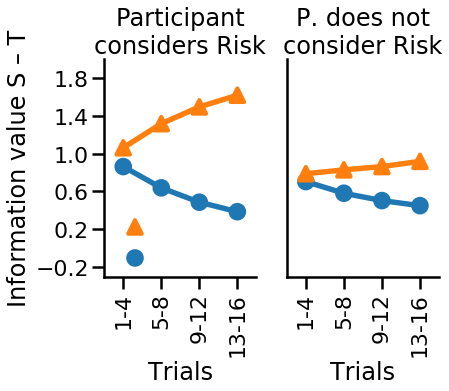

In [42]:
sns.set_context('poster')
fig, ax = plt.subplots(1,2,figsize=[6,4], sharey=False)

# yes risk
sns.pointplot(data = plot_dat.query('Risk == True'),
             x = 'trialbin', y = 'diff KL S>T',
              hue = 'player_type', hue_order = ['opt_nat','pess_nat'],
             ax = ax[0], capsize = .1, errwidth = 1,
             markers = ['o','^'])
ax[0].set(ylabel = 'Information value S – T', xlabel = 'Trials',
       xticklabels = ['1-4','5-8','9-12','13-16'], yticks = np.arange(-.2,2.1,.4),
       title = 'Participant\nconsiders Risk', ylim = [-.3,2]);
hand,lab = ax[0].get_legend_handles_labels()
lab = ['Optimist', 'Pessimist']
ax[0].legend([hand[i] for i in [1,0]],
             ['',''],
             loc = [0,0], ncol=1, title = None,
            frameon=False)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)

# no risk
sns.pointplot(data = plot_dat.query('Risk == False'),
             x = 'trialbin', y = 'diff KL S>T',
              hue = 'player_type', hue_order = ['opt_nat','pess_nat'],
             ax = ax[1], capsize = .1, errwidth = 1,
             markers = ['o','^'])
ax[1].set(ylabel = None, xlabel = 'Trials',
       xticklabels = ['1-4','5-8','9-12','13-16'],
       title = 'P. does not\nconsider Risk', yticks = [], ylim = [-.3,2]);
ax[1].get_legend().remove()
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90);

sns.despine(top=True, right = True)